# DPA (Dual Pipeline Attentional Multimodal Fusion)

In [838]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from keras.callbacks import EarlyStopping
from keras.layers import (Activation, Attention, Bidirectional, Concatenate, Conv1D,
                           Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D,
                           Input, Layer, LSTM, MaxPooling1D, Multiply, Permute,
                           RepeatVector, Reshape, SpatialDropout1D, TimeDistributed)
from keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

#import our own library cs16
import sys
sys.path.append('./cs16')
import cs16.prep as prep16
import cs16.plot as plot16
import cs16.build as build16
imagesize = 64

#----------------------------------------------------
# select a dataset
#----------------------------------------------------
data_type = input("Enter '1. single' for single dataset or '2. multi' for multiple dataset: ")

if data_type == '1':
    file_path = 'single.txt'
    folder_path = './data/MVSA/single/'
elif data_type == '2':
    file_path = 'multi.txt'
    folder_path = './data/MVSA/multiple/'
else:
    print("Invalid input. Please enter either 'single' or 'multi'.")
    exit()

df = pd.read_csv(file_path, index_col=None, encoding='ISO-8859-1')


Enter '1. single' for single dataset or '2. multi' for multiple dataset: 2


In [839]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
# Download stopwords and punkt tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
#----------------------------------------------------
# NLP preprocess
#----------------------------------------------------
# Define a function to preprocess text
def nlp_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs 
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stem words using Porter Stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text

# call function
df['tweet'] = df['tweet'].apply(nlp_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [840]:
#----------------------------------------------------
# Data preprocess and split
#----------------------------------------------------

#----------text---------
X_text, y_text = prep16.preprocess_text(df)
X_train_text, X_val_text, X_test_text, \
y_train_text, y_val_text, y_test_text = prep16.split_data(X_text, y_text, random_state=42)

#----------polarity---------
X_polar, y_polar = prep16.preprocess_text(df,label = 'polarity')
X_train_polar, X_val_polar, X_test_polar, \
y_train_polar, y_val_polar, y_test_polar = prep16.split_data(X_polar, y_polar, random_state=42)

#----------image---------
image_data_s, image_label_s = prep16.preprocess_images(df, folder_path, imagesize)
y_s = to_categorical(image_label_s, num_classes=3)

X_train_image, X_val_image, X_test_image, \
y_train_image, y_val_image, y_test_image= prep16.split_data(image_data_s, y_s, random_state=42)

#----------one-hot---------
y_train = to_categorical(y_train_polar, num_classes=3)
y_val =to_categorical(y_val_polar, num_classes=3)
y_test =to_categorical(y_test_polar, num_classes=3)
print(file_path)

multi.txt


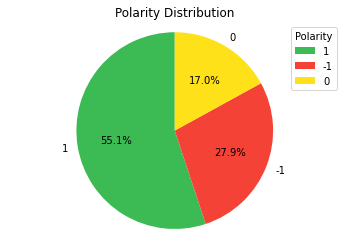

In [746]:
import pandas as pd
import matplotlib.pyplot as plt
# distribution of polarity
polarity_counts =df['polarity'].value_counts(normalize=True)

# assign colors for each category
colors = ['#3cba54', '#f44336', '#ffe119']

# Create a pie chart of the polarity distribution
plt.pie(polarity_counts.values, labels=polarity_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Polarity Distribution')
plt.legend(title='Polarity', loc='best')
plt.show()

# TEXT

In [4]:
class ContentAttention(Layer):
    def __init__(self, **kwargs):
        super(ContentAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(ContentAttention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)   


# Bi-LSTM 

In [841]:
#import AveragePooling2D
from keras.layers import (AveragePooling1D)
from tensorflow.keras import regularizers

text_af = 'tanh'
text_input = Input(shape=(100,), name='text_input')

#----------LSTM1----------------
lstm1 = Embedding(input_dim=10000, output_dim=100)(text_input)
lstm1 = Dropout(0.5)(lstm1)  # Add a dropout layer
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
#lstm1 = Dense(64, activation=text_af, kernel_regularizer=regularizers.l2(0.01))(lstm1)
lstm1 = ContentAttention()(lstm1)
lstm1 = Dropout(0.5)(lstm1)  # Add a dropout layer

#---------LSTM2-----------------
lstm2 = Embedding(input_dim=10000, output_dim=100)(text_input)
lstm2 = Dropout(0.5)(lstm2)  # Add a dropout layer
lstm2 = Bidirectional(LSTM(128, return_sequences=True))(lstm2)
#lstm2 = Dense(64, activation=text_af, kernel_regularizer=regularizers.l2(0.01))(lstm2)
lstm2 = ContentAttention()(lstm2)
lstm2 = Dropout(0.5)(lstm2)  # Add a dropout layer

#----------local fusion---------------
merged_layer = Concatenate()([lstm1, lstm2]) 
merged = Dense(3, activation='tanh')(merged_layer)
text_output = merged
textclassifier ='BiLSTM + BiLSTM'
print(textclassifier)

BiLSTM + BiLSTM


# Image

# CNN +  EfficientNet

In [959]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

imageclassifier = 'CNN+ EfficientNet'

# ------------ pipeline1:CNN --------------------------
image_input = Input(shape=(imagesize, imagesize, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)
pool1 = BatchNormalization()(pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.25)(pool2)
pool2 = BatchNormalization()(pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.25)(pool3)
pool3 = BatchNormalization()(pool3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(0.25)(pool4)
pool4 = BatchNormalization()(pool4)

# Add spatial attention to CNN features
cnn1_attention = Conv2D(1, (1, 1), activation='sigmoid')(pool4)
attended_features = Multiply()([pool4, cnn1_attention])

cnn1_flatten = Flatten()(attended_features)

#--------------pipeline2: EfficientNet--------------------------------
from efficientnet.tfkeras import EfficientNetB0, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
efficientnet = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(imagesize, imagesize, 3))

for layer in efficientnet.layers:
    layer.trainable = False

processed_image = efficientnet_preprocess_input(image_input)
efficientnet_features = efficientnet(processed_image)

#Add spatial attention
efficientnet_attention = Conv2D(1, (1, 1), activation='sigmoid')(efficientnet_features)
attended_features = Multiply()([efficientnet_features, efficientnet_attention])

#Flatten the attended features
efficientnet_flatten = Flatten()(attended_features)

#----------local fusion---------------
merged_features = Concatenate()([cnn1_flatten, efficientnet_flatten])

# Apply the rest of the model layers
merged = Dense(256, activation='relu')(merged_features)
merged = Dropout(0.5)(merged)
image_output = Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.05))(merged)

print(imageclassifier)

258434480/258434480 [==============================] - 129s 0us/step
CNN+ EfficientNet


# Fusion

In [960]:
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import backend as K
from keras import metrics

#----------Global fusion---------------
concatenated = Concatenate()([text_output, image_output])
# Final output layers
output = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(concatenated)
model = Model(inputs=[text_input, image_input], outputs=output)
print(file_path)
print(f"Text:{textclassifier},Image:{imageclassifier}")
# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit([X_train_text, X_train_image], y_train, 
                    validation_data=([X_val_text, X_val_image], y_val),
                    epochs=10, 
                    batch_size=64)

# Evaluate the model
test_loss, test_acc = model.evaluate([X_test_text, X_test_image], y_test)
print('Test accuracy:', test_acc)


multi.txt
Text:BiLSTM + BiLSTM,Image:CNN+ EfficientNet
Epoch 1/10
244/244 [==============================] - 1039s 4s/step - loss: 0.8665 - accuracy: 0.7999 - val_loss: 0.7995 - val_accuracy: 0.7031
Epoch 2/10
244/244 [==============================] - 1116s 5s/step - loss: 0.5138 - accuracy: 0.8600 - val_loss: 0.8028 - val_accuracy: 0.6836
Epoch 3/10
244/244 [==============================] - 1138s 5s/step - loss: 0.4366 - accuracy: 0.8663 - val_loss: 0.8250 - val_accuracy: 0.6893
Epoch 4/10
244/244 [==============================] - 1102s 5s/step - loss: 0.4030 - accuracy: 0.8701 - val_loss: 0.8310 - val_accuracy: 0.7042
Epoch 5/10
244/244 [==============================] - 1096s 4s/step - loss: 0.3813 - accuracy: 0.8790 - val_loss: 0.8705 - val_accuracy: 0.6959
Epoch 6/10
244/244 [==============================] - 1086s 4s/step - loss: 0.3655 - accuracy: 0.8905 - val_loss: 0.9136 - val_accuracy: 0.6759
Epoch 7/10
244/244 [==============================] - 1101s 5s/step - loss: 0.348

# Metrics

In [1003]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on test data
y_pred = model.predict([X_test_text, X_test_image])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, digits = 4)
print(f"image:{imageclassifier}, Text:{textclassifier}")
# Print the report
print('Classification Report:\n', report)


61/61 [==============================] - 155s 3s/step
image:CNN+ EfficientNet, Text:BiLSTM + BiLSTM
Classification Report:
               precision    recall  f1-score   support

           0     0.1538    0.1417    0.1475       254
           1     0.8030    0.8090    0.8060      1461
           2     0.3000    0.3117    0.3057       231

    accuracy                         0.6629      1946
   macro avg     0.4189    0.4208    0.4198      1946
weighted avg     0.6586    0.6629    0.6607      1946



# LATE FUSION

In [962]:
#----------------image----------------
image_feature_extractor = Model(inputs=image_input, outputs=image_output)

val_image_features = image_feature_extractor.predict(X_val_image)
test_image_features = image_feature_extractor.predict(X_test_image)

#--------------text----------------
text_feature_extractor = Model(inputs=text_input, outputs=text_output)

val_text_features = text_feature_extractor.predict(X_val_text)
test_text_features = text_feature_extractor.predict(X_test_text)

#---------------combine----------------
val_features = np.concatenate([val_image_features, val_text_features], axis=1)
test_features = np.concatenate([test_image_features, test_text_features], axis=1)

# one-hot encoded vectors if needed
y_val_labels = y_val_polar #np.argmax(y_val_image, axis=1)
y_test_labels = y_test_polar#np.argmax(y_test_image, axis=1)


61/61 [==============================] - 30s 492ms/step


## XGB

In [990]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_val_labels_encoded = label_encoder.fit_transform(y_val_labels)
y_test_labels_encoded = label_encoder.transform(y_test_labels)

xgb_model = xgb.XGBClassifier(n_estimators=113, max_depth=3) #reg_lambda reg_alpha

# Train the XGBoost model
xgb_model.fit(val_features, y_val_labels_encoded)

# Evaluate the model
xgb_score = xgb_model.score(test_features, y_test_labels_encoded)
print("Late Fusion Test Accuracy: {:.2f}%".format(xgb_score * 100))
print(f"image:{imageclassifier}, Text:{textclassifier}")
y_pred = xgb_model.predict(test_features)

# Print classification report
print(classification_report(y_test_labels_encoded, y_pred, digits=4))

Late Fusion Test Accuracy: 74.15%
image:CNN+ EfficientNet, Text:BiLSTM + BiLSTM
              precision    recall  f1-score   support

           0     0.3711    0.1558    0.2195       231
           1     0.2545    0.0551    0.0906       254
           2     0.7765    0.9535    0.8559      1461

    accuracy                         0.7415      1946
   macro avg     0.4674    0.3881    0.3887      1946
weighted avg     0.6602    0.7415    0.6805      1946



## Random Forest

In [1000]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=11)

rf.fit(val_features, y_val_labels)
rf_score = rf.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(rf_score * 100))
#from sklearn.metrics import classification_report

# Predict labels for test data
y_pred = rf.predict(test_features)
print(f"image:{imageclassifier}, Text:{textclassifier}")
# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 73.95%
image:CNN+ EfficientNet, Text:BiLSTM + BiLSTM
              precision    recall  f1-score   support

          -1     0.3553    0.1169    0.1759       231
           0     0.1714    0.0236    0.0415       254
           1     0.7662    0.9624    0.8532      1461

    accuracy                         0.7395      1946
   macro avg     0.4310    0.3676    0.3569      1946
weighted avg     0.6398    0.7395    0.6668      1946



## MLP

In [1002]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 32), 
                    activation='relu', solver='lbfgs', learning_rate = 'invscaling')

# Fit the classifier to the training data
mlp.fit(val_features, y_val_labels)

# Evaluate the classifier on the test data
mlp_score = mlp.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(mlp_score * 100))

# Predict labels for the test data
y_pred = mlp.predict(test_features)

# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 74.41%
              precision    recall  f1-score   support

          -1     0.3529    0.1299    0.1899       231
           0     0.0000    0.0000    0.0000       254
           1     0.7628    0.9706    0.8542      1461

    accuracy                         0.7441      1946
   macro avg     0.3719    0.3668    0.3480      1946
weighted avg     0.6146    0.7441    0.6639      1946



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


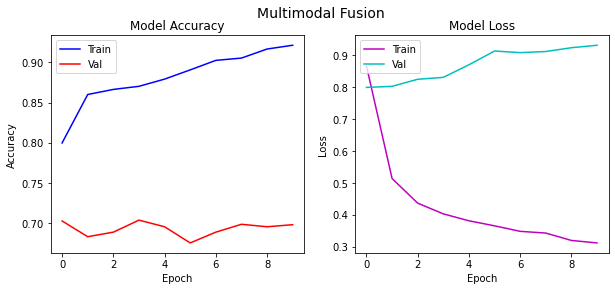

In [1004]:
plot16.plot_hist(history, 'Multimodal Fusion')

61/61 [==============================] - 139s 2s/step


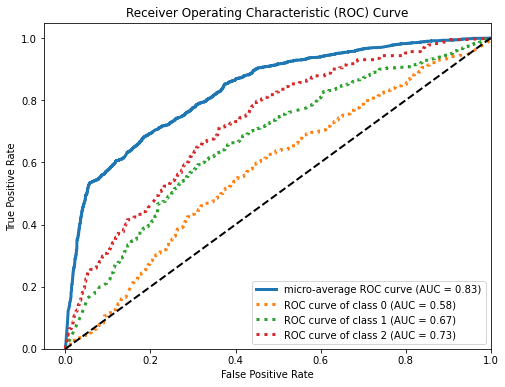

In [1005]:
X_test = [X_test_text, X_test_image]
plot16.plot_roc(model, X_test, y_test)